# This notebook creates the figures used in: 

Knobelspiesse, K.D., B. Cairns, I. Cetinić, I., S. LeBlanc, and S. Nicholas. Field campaign design and implementation with traceability matrix decision support. *To submit to Journal of Atmospheric and Oceanic Technology*.


In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon


#
#
# Equations

#### Time fulfillment function, eqn 1

This function expresses the fulfillment of a measurement objective given the observation time threshold requirement $h$ and the actual observation time $t$

$f(t,h) = 1- e^{-\frac{t}{h}}$

In [2]:
# time fulfillment function eqn 1
# f(t,h) = 1 - e^ (-t / h)
#  h: observation time threshold requirement
#  t: observation time

def fcn_timeful(t_input, h_input):
    tt=np.asarray(t_input)
    hh=np.asarray(h_input)
    
    f = 1.0 - np.exp( -1.0*tt/hh ) #see equation 1

    return f

#### Potential success function, eqn 4
$S(t) = \frac{1}{\sum_{i=1}^n w_i} \sum\limits_{i=1}^n 
    w_i c_i \left( 1 - e^{-\frac{t p_i w_i}{\sum_{j=1}^n w_j h_j}} \right)$



In [3]:
# potential success function eqn 4

def fcn_psf(df_input,t_input):
    sum_wgt = df_input['Weight'].sum()
    
    aa=df_input['Weight'] * df_input['ObsTime']
    sum_wgtobs=aa.sum()

    S_out = 0.0
    for index, row in df_input.iterrows():
        inparentheses = 1.0 - np.exp( -1.0*(t_input*row['Probability']*row['Weight'])/sum_wgtobs )
        S_out = S_out + row['Weight']*row['Completeness']*inparentheses
    S_out = S_out / sum_wgt
    
    return S_out

#### Potential success function maximum, eqn 5
$S(t \rightarrow \infty) = \frac{\sum_{i=1}^{n} w_i c_i}{\sum_{i=1}^{n} w_i} $


In [4]:
# potential success function maximumm eqn 5

def fcn_psfm(df_input):
    sum_wgt = df_input['Weight'].sum()
    aa=df_input['Weight'] * df_input['Completeness']
    sum_wgtcmp=aa.sum()
    psfm=np.divide(sum_wgtcmp,sum_wgt)
    
    return psfm

#### Achievement function, eqn 6
$ A (\mathbf{t}_a) = 
 \frac{1}{\sum_{i=1}^n w_i} 
 \sum\limits_{i=1}^n w_i c_i \left( 1 - e^{-\frac{t_{a,i}}{h_i}} \right) $

In [5]:
# Achievement function eqn 6
def fcn_achieve(df_vtm, df_hours_in):
    sum_wgt = df_vtm['Weight'].sum()
    
    t_a=np.asarray(np.asarray(df_hours_in.sum())[1:],dtype=np.float64) #this assumes hours columns begin at column 1

    A_out = 0.0
    for index, row in df_vtm.iterrows():
        inparentheses = 1.0 - np.exp( -1.0*t_a[index]/row['ObsTime'] )
        A_out = A_out + row['Weight']*row['Completeness']*inparentheses
    A_out = A_out / sum_wgt
    
    return A_out

#### Remaining objective function, eqn 7
$ R (\mathbf{t}_{a,i}) = 
 \frac{w_i c_i}{\sum_{i=1}^n w_i} 
  e^{-\frac{t_{a,i}}{h_i}} $

In [6]:
# Remaining objective function eqn 7
# calculation performed for all VTM elements
def fcn_remaining(df_vtm, df_hours_in):
    sum_wgt = df_vtm['Weight'].sum()
    
    t_a=np.asarray(np.asarray(df_hours_in.sum())[1:],dtype=np.float64) #this assumes hours columns begin at column 1

    R_out = np.zeros(df_vtm.shape[0])

    for index, row in df_vtm.iterrows():
        expfcn = np.exp( -1.0*t_a[index]/row['ObsTime'] )
        R_out[index] = row['Weight']*row['Completeness']*expfcn/sum_wgt
    
    return R_out

#### Expectation function, eqn 8
$ E_x(\mathbf{t}_x,\mathbf{t}_a,\mathbf{p}_x) 
= S(\mathbf{t}_x+\mathbf{t}_a,\mathbf{p}_x) - A(\mathbf{t}_a)
= \frac{1}{\sum_{i=1}^n w_i} 
\left[ \sum\limits_{i=1}^n w_i c_i \left( e^{-\frac{t_{a,i}}{h_i}} -
     e^{-\frac{t_{a,i}+p_{x,i}t_{x,i}}{h_i}} \right) 
\right]$



In [7]:
#expectation function, equation 8
def fcn_expect(df_vtm, df_hours_in, tx, px):
    sum_wgt = df_vtm['Weight'].sum()

    t_a=np.asarray(np.asarray(df_hours_in.sum())[1:],dtype=np.float64) #this assumes hours columns begin at column 1

    E_out = 0.0
    for index, row in df_vtm.iterrows():
        inparenthesesA = np.exp( -1.0 * t_a[index] / row['ObsTime'] )
        inparenthesesB = np.exp( -1.0 * ( t_a[index] + px[index] * tx[index] ) / row['ObsTime'] )        
        E_out = E_out + row['Weight']*row['Completeness']*(inparenthesesA-inparenthesesB)
    E_out = E_out / sum_wgt
     
    return E_out

#### Probability adjustment for climatological expectation function, eqn 9
$ p'_{c,i}= 1 - \left( 1 - p_{c,i}\right)^{(d - \frac{\eta}{\varepsilon})} $ for $ d \gt \frac{\eta}{\varepsilon} $


$ p'_{c,i}= 0 $ for $ d \le \frac{\eta}{\varepsilon} $

In [8]:
#Probability adjustment for climatological expectation function, eqn 9
def fcn_probadj(p_in, days_rem, flthrs_rem, hpd):

    p_out = np.zeros(p_in.shape[0])
    if days_rem > (flthrs_rem/hpd):
        for idx in range(len(p_out)):
            p_out[idx] = 1.0 - (1.0 - p_in[idx])**(days_rem - (flthrs_rem/hpd) )

    return p_out

#### Time partitioning for climatological expectation function, eqn 10
$t_{c,i} = \frac{R_i(t_{a,i})\sum_{k=1}^{n} t_{x,k}}{\sum_{j=1}^{n} R_j(t_{a,j})} $

In [9]:
#time partitioning for climatological expectation function, eqn 10
def fcn_timepart(R_in, tx, p_in):

    t_out = tx

    R_p = np.multiply(R_in, p_in)

    if p_in.sum() > 0.0:
        for idx in range(len(tx)):
            t_out[idx] = R_in[idx] * p_in[idx] * tx.sum() / R_p.sum()

    return t_out

#
#
# Data

#### Create dataframe for theoretical field campaign Alpha, Beta, Gamma

In [10]:
#create dataframe for theoretical field campaign Alpha, Beta, Gamma

data = {
  "Label": ['A','B','C','D'],
  "Weight": [8,7,4,1],
  "ObsTime": [2,3,2,1],
  "Completeness": [1.0,1.0,1.0,1.0],
  "Probability": [0.3,0.3,0.3,0.3],    
}
df_alpha = pd.DataFrame(data)

data = {
  "Label": ['A','B','C','D'],
  "Weight": [8,7,4,1],
  "ObsTime": [2,3,2,1],
  "Completeness": [1.0,1.0,0.0,0.0],
  "Probability": [0.98,0.98,0.0,0.0],    
}
df_beta = pd.DataFrame(data)

data = {
  "Label": ['A','B','C','D'],
  "Weight": [8,7,4,1],
  "ObsTime": [2,3,2,1],
  "Completeness": [1.0,1.0,.8,0.0],
  "Probability": [0.5,0.5,0.5,0.0],    
}
df_gamma = pd.DataFrame(data)


In [11]:
display(df_alpha)
print('S(max)%.3f' % fcn_psfm(df_alpha))
print()

display(df_beta)
print('S(max) = %.3f' % fcn_psfm(df_beta))
print()

display(df_gamma)
print('S(max) = %.3f' % fcn_psfm(df_gamma))



,Label,Weight,ObsTime,Completeness,Probability
0,A,8,2,1.0,0.3
1,B,7,3,1.0,0.3
2,C,4,2,1.0,0.3
3,D,1,1,1.0,0.3


S(max)1.000



,Label,Weight,ObsTime,Completeness,Probability
0,A,8,2,1.0,0.98
1,B,7,3,1.0,0.98
2,C,4,2,0.0,0.00
3,D,1,1,0.0,0.00


S(max) = 0.750



,Label,Weight,ObsTime,Completeness,Probability
0,A,8,2,1.0,0.5
1,B,7,3,1.0,0.5
2,C,4,2,0.8,0.5
3,D,1,1,0.0,0.0


S(max) = 0.910


#### Create observation time spent dataframe

In [67]:
#create dataframe in support of PC-DSA, indicating time spent

data = {
  "Date": ['Day 1','Day 2','Day 3','Day 4','Day 5','Day 6','Day 7',
           'Day 8','Day 9','Day 10','Day 11','Day 12','Day 13','Day 14','Day 15'],
  "A time":   [0.0, 0.5, 0.0, 1.0, 0.0, 0.0, 1.0, 0.5, 0.0, 1.5, 0.0, 0.5, 0.0, 1.0, 0.5],
  "B time":   [0.0, 0.5, 1.0, 0.5, 2.0, 0.0, 0.0, 1.5, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 1.0],
  "C time":   [0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.5, 0.0, 1.0, 0.0],
  "D time":   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0],
}
df_hours = pd.DataFrame(data)
df_hours

,Date,A time,B time,C time,D time
0,Day 1,0.0,0.0,0.0,0.0
1,Day 2,0.5,0.5,0.0,0.0
2,Day 3,0.0,1.0,0.0,0.0
3,Day 4,1.0,0.5,0.0,0.0
4,Day 5,0.0,2.0,0.5,0.0
5,Day 6,0.0,0.0,0.0,0.0
6,Day 7,1.0,0.0,1.0,0.0
7,Day 8,0.5,1.5,1.0,0.5
8,Day 9,0.0,0.0,0.0,0.0
9,Day 10,1.5,0.0,0.0,0.5


In [35]:
#create dataframe for PACE-PAX VTM

#objective: Validate new retrieval properties
data_newret = {
  "Label": ['1a',
            '1b',
            '1c',
            '1d',
            '1e',
            '1f'],
  "Description": 
           ['New retrievals: land',
            'New retrievals: ocean',
            'New retrievals: aerosol+ocean',
            'New retrievals: aerosol+land',
            'New retrievals: cloud',
            'New retrievals: ocean surface'],
  "Weight": [8,10,12,12,12,1],
  "ObsTime": [2,8,8,8,8,8],
  "Completeness": [1.0,1.0,1.0,1.0,1.0,0.5],
  "Probability": [0.5,0.5,0.5,0.75,0.5,0.25],    
}
df_newret = pd.DataFrame(data_newret)

#objective: Validate in a narrow swath
data_narrow = {
  "Label": ['2a',
            '2b',
            '2c',
            '2d',
            '2e'],
  "Description": 
           ['PACE: aerosol+ocean',
            'PACE: aerosol+land',
            'PACE: cloud',
            'EarthCARE: aerosol',
            'EarthCARE: cloud'],
  "Weight": [10, 10, 5, 8, 8],
  "ObsTime": [8.0, 8.0, 2.0, 4.0, 4.0],
  "Completeness": [1.0,1.0,1.0,1.0,1.0],
  "Probability": [0.5,0.5,0.5,0.25,0.25],    
}
df_narrow = pd.DataFrame(data_narrow)

#objective: Validate radiometric and polarimetric properties
data_rad = {
  "Label": ['3a',
            '3b',
            '3c',
            '3d'],
  "Description": 
           ['Large reflectances',
            'Large reflectance high polarization',
            'Large reflectance low polarization',
            'Vicarious calibration sites'],
  "Weight": [6, 6, 6, 6],
  "ObsTime": [2.0, 2.0, 2.0, 4.0],
  "Completeness": [1.0,1.0,1.0,1.0],
  "Probability": [0.5,0.75,0.75,0.25],    
}
df_rad = pd.DataFrame(data_rad)

#objective: Focus on specific processes or phenomena
data_specific = {
  "Label": ['4a',
            '4b',
            '4c',
            '4d',
            '4e',
            '4f',
            '4g',           
            '4h',
            '4i',
            '4j'],
  "Description": 
           ['High aerosol over land',
            'High aerosol over ocean',
            'Multiple aerosol layers',
            'Aerosol under cirrus',
            'Aerosol above liquid cloud',
            'Broken cloud',
            'Dust over ocean',
            'Aerosol+ocean, turbid water',
            'Aerosol+ocean, productive water',         
            'Smoke over ocean'],
  "Weight": [4, 4, 1, 2, 4, 4, 4, 2, 4, 1],
  "ObsTime": [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0],
  "Completeness": [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
  "Probability": [0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25],    
}
df_specific = pd.DataFrame(data_specific)

df_pacepax = pd.concat([df_newret, df_narrow, df_rad, df_specific], ignore_index=True)
#df_pacepax.append(data_newret)

df_pacepax

,Label,Description,Weight,ObsTime,Completeness,Probability
0,1a,New retrievals: land,8,2.0,1.0,0.50
1,1b,New retrievals: ocean,10,8.0,1.0,0.50
2,1c,New retrievals: aerosol+ocean,12,8.0,1.0,0.50
3,1d,New retrievals: aerosol+land,12,8.0,1.0,0.75
4,1e,New retrievals: cloud,12,8.0,1.0,0.50
5,1f,New retrievals: ocean surface,1,8.0,0.5,0.25
6,2a,PACE: aerosol+ocean,10,8.0,1.0,0.50
7,2b,PACE: aerosol+land,10,8.0,1.0,0.50
8,2c,PACE: cloud,5,2.0,1.0,0.50
9,2d,EarthCARE: aerosol,8,4.0,1.0,0.25


In [130]:
#create dataframe indicating time spent for PACE-PAX

data = {
  "Date":['CF0828','CF0829','RF0903','RF0904','RF0906','RF0907','RF0908','RF0910','RF0912','RF0913','RF0915','RF0917','RF0918','RF0919','RF0920','RF0922','RF0923','RF0924','RF0926','RF0927','RF0929','RF0930'],
  "1a":   [0.00000, 0.45000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.12500, 0.00000, 1.00000, 0.00000, 4.00000, 0.00000, 0.00000, 0.00000, 1.50000, 0.00000, 0.00000, 0.00000, 0.00000, 1.50000, 2.00000],
  "1b":   [0.00000, 0.00000, 0.00000, 0.00000, 6.50000, 0.00000, 8.00000, 2.00000, 6.00000, 1.50000, 1.50000, 8.00000, 3.00000, 4.00000, 2.00000, 0.00000, 0.00000, 0.00000, 8.00000, 4.00000, 3.50000, 2.50000],
  "1c":   [0.00000, 0.00000, 0.00000, 0.50000, 9.25000, 0.00000, 2.00000, 2.00000, 2.62500, 1.50000, 1.50000, 5.00000, 2.00000, 3.00000, 2.00000, 0.00000, 0.00000, 0.00000, 9.50000, 5.00000, 3.50000, 2.50000],
  "1d":   [0.00000, 4.00000, 4.05000, 2.00000, 3.00000, 0.00000, 7.85000, 2.02500, 1.12500, 18.5000, 0.00000, 3.00000, 0.00000, 1.50000, 0.00000, 8.00000, 6.00000, 0.00000, 7.00000, 3.00000, 3.00000, 3.00000],
  "1e":   [0.00000, 0.00000, 0.00000, 4.00000, 0.00000, 3.00000, 0.00000, 0.00000, 0.00000, 0.00000, 2.50000, 0.00000, 0.00000, 0.00000, 3.00000, 1.00000, 3.00000, 0.75000, 0.00000, 2.00000, 0.00000, 1.00000],
  "1f":   [0.00000, 0.00000, 0.00000, 0.00000, 2.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.50000, 0.00000, 0.00000, 0.00000],
  "2a":   [0.00000, 0.00000, 0.00000, 0.00000, 2.00000, 0.00000, 0.00000, 0.00000, 1.50000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 2.00000],
  "2b":   [0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 1.12500, 0.00000, 0.00000, 2.00000, 0.00000, 0.00000, 0.00000, 0.00000, 2.00000, 0.00000, 2.00000, 0.00000, 3.00000, 0.00000],
  "2c":   [0.00000, 0.00000, 0.00000, 1.00000, 0.50000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 2.00000, 0.00000, 0.50000],
  "2d":   [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 2.50000, 0.00000, 0.00000, 0.00000, 0.00000, 3.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 2.00000, 0.00000, 0.00000, 2.50000],
  "2e":   [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.50000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
  "3a":   [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.12500, 0.00000, 1.00000, 0.00000, 4.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.50000],
  "3b":   [0.00000, 0.00000, 0.00000, 0.00000, 2.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.50000, 0.00000, 1.00000, 0.00000],
  "3c":   [0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.50000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 2.50000, 1.50000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000],
  "3d":   [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.25000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.50000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
  "4a":   [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 2.25000, 0.00000, 17.5000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.50000, 0.00000],
  "4b":   [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
  "4c":   [0.00000, 0.50000, 4.05000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 17.5000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 4.50000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
  "4d":   [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 3.50000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
  "4e":   [0.00000, 0.50000, 0.00000, 0.00000, 0.00000, 3.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.50000, 0.00000, 0.00000, 0.00000, 0.00000],
  "4f":   [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.50000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 2.00000, 0.00000, 0.00000],
  "4g":   [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.12500, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
  "4h":   [0.00000, 0.00000, 0.00000, 0.50000, 0.00000, 0.00000, 0.00000, 0.00000, 2.62500, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.50000, 0.50000, 0.50000, 0.50000, 0.75000],
  "4i":   [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 4.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.50000, 1.50000, 2.50000, 1.00000, 0.25000], 
  "4j":   [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 1.50000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
}
df_pacepax_hrs = pd.DataFrame(data)
pd.set_option('display.max_columns', 50)


df_pacepax_hrs

,Date,1a,1b,1c,1d,1e,1f,2a,2b,2c,2d,2e,3a,3b,3c,3d,4a,4b,4c,4d,4e,4f,4g,4h,4i,4j
0,CF0828,0.000,0.0,0.000,0.000,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.000,0.000,0.00,0.0
1,CF0829,0.450,0.0,0.000,4.000,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.00,0.00,0.0,0.50,0.0,0.5,0.0,0.000,0.000,0.00,0.0
2,RF0903,0.000,0.0,0.000,4.050,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.00,0.00,0.0,4.05,0.0,0.0,0.0,0.000,0.000,0.00,0.0
3,RF0904,0.000,0.0,0.500,2.000,4.00,0.0,0.0,0.000,1.0,0.0,0.0,0.000,0.0,1.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.000,0.500,0.00,0.0
4,RF0906,0.000,6.5,9.250,3.000,0.00,2.0,2.0,1.000,0.5,0.0,0.0,0.000,2.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.000,0.000,0.00,0.0
5,RF0907,0.000,0.0,0.000,0.000,3.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.00,0.00,0.0,0.00,0.0,3.0,0.0,0.000,0.000,0.00,0.0
6,RF0908,0.000,8.0,2.000,7.850,0.00,0.0,0.0,0.000,0.0,2.5,0.5,0.000,0.0,0.5,0.00,1.00,1.0,0.00,0.0,0.0,0.0,0.000,0.000,0.00,1.0
7,RF0910,0.125,2.0,2.000,2.025,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.125,0.0,0.0,1.25,2.25,0.0,0.00,0.0,0.0,0.0,0.000,0.000,0.00,0.0
8,RF0912,0.000,6.0,2.625,1.125,0.00,0.0,1.5,1.125,0.0,0.0,0.0,0.000,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,1.125,2.625,0.00,0.0
9,RF0913,1.000,1.5,1.500,18.500,0.00,0.0,0.0,0.000,0.0,0.0,0.0,1.000,0.0,1.0,0.00,17.50,0.0,17.50,0.0,0.0,0.0,0.000,0.000,0.00,1.5


#
#
# Manuscript calculations and figures

<Figure size 640x480 with 0 Axes>

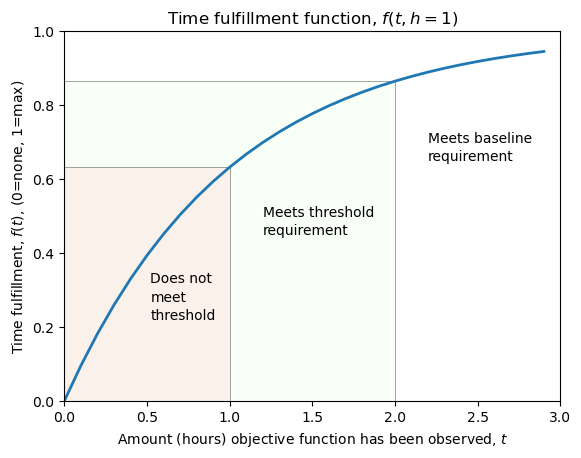

In [131]:
# Create Figure 1: Time fulfillment function

fig = plt.figure()
fix, ax = plt.subplots()

pltmax=3.0
pltstep=0.1

obs_time = np.arange(0,pltmax,pltstep)
fulfil = fcn_timeful(obs_time,1.0)

ax.plot(obs_time,fulfil,linewidth=2)
ax.set_title(r'Time fulfillment function, $\it{f(t,h=1)}$')
ax.set_xlabel(r'Amount (hours) objective function has been observed, $\it{t}$')
ax.set_ylabel(r'Time fulfillment, $\it{f(t)}$, (0=none, 1=max)')
#plt.grid(True, color = "grey", linewidth = "0.5", linestyle = "-.")
ax.set_xlim(0,pltmax)
ax.set_ylim(0,1)

rect_baseline = Rectangle((0., 0.), width=2, height=0.86466472, alpha=0.5,
                 facecolor='honeydew',edgecolor='black',linewidth=0.5)
ax.add_patch(rect_baseline)
rect_threshold = Rectangle((0., 0.), width=1, height=0.63212056, alpha=0.5, 
                 facecolor='mistyrose',edgecolor='black',linewidth=0.5)
ax.add_patch(rect_threshold)

plt.text(0.52,0.32,'Does not')
plt.text(0.52,0.27,'meet')
plt.text(0.52,0.22,'threshold')

plt.text(1.2,0.5,'Meets threshold')
plt.text(1.2,0.45,'requirement')

plt.text(2.2,0.7,'Meets baseline')
plt.text(2.2,0.65,'requirement')

plt.savefig("VTM_fig1.pdf", format="pdf", bbox_inches="tight")
plt.show()


<Figure size 640x480 with 0 Axes>

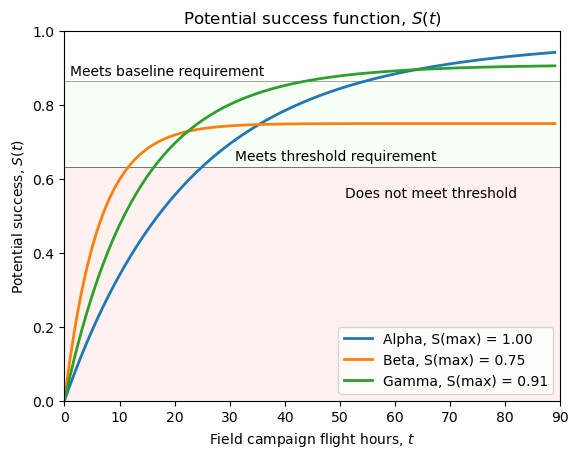

In [132]:
# Create Figure 2: Potential success function

fig = plt.figure()
fix, ax = plt.subplots()

pltmax=90.0
pltstep=1
obs_time = np.arange(0,pltmax,pltstep)

S_alpha = fcn_psf(df_alpha,obs_time)
Smax_alpha = fcn_psfm(df_alpha)
S_beta = fcn_psf(df_beta,obs_time)
Smax_beta = fcn_psfm(df_beta)
S_gamma = fcn_psf(df_gamma,obs_time)
Smax_gamma = fcn_psfm(df_gamma)
                      
#ax.plot([0,pltmax],[.632,.632],label='Threshold',linestyle='--',color='grey',linewidth = "0.75")
#ax.plot([0,pltmax],[.865,.865],label='Baseline',linestyle='-.',color='black',linewidth = "0.75")
ax.plot(obs_time,S_alpha,label=r'Alpha, S(max) = %.2f' % Smax_alpha, linewidth='2')
ax.plot(obs_time,S_beta,label=r'Beta, S(max) = %.2f' % Smax_beta, linewidth='2')
ax.plot(obs_time,S_gamma,label=r'Gamma, S(max) = %.2f' % Smax_gamma, linewidth='2')
ax.set_title(r'Potential success function, $\it{S(t)}$')
ax.set_xlabel(r'Field campaign flight hours, $\it{t}$')
ax.set_ylabel(r'Potential success, $\it{S(t)}$')
#plt.grid(True, color = "grey", linewidth = "0.5", linestyle = "-.")
ax.set_xlim(0,pltmax)
ax.set_ylim(0,1)
ax.legend()


rect_baseline = Rectangle((0.0,0.632), width=pltmax, height=0.865-0.632, alpha=0.5,
                 facecolor='honeydew',edgecolor='black',linewidth=0.5)
ax.add_patch(rect_baseline)
rect_threshold = Rectangle((0.0,0.0), width=pltmax, height=0.632, alpha=0.5, 
                 facecolor='mistyrose',edgecolor='black',linewidth=0.5)
ax.add_patch(rect_threshold)

plt.text(51,0.55,'Does not meet threshold')

plt.text(31,0.65,'Meets threshold requirement')

plt.text(1,0.88,'Meets baseline requirement')


plt.savefig("VTM_fig2.pdf", format="pdf", bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>

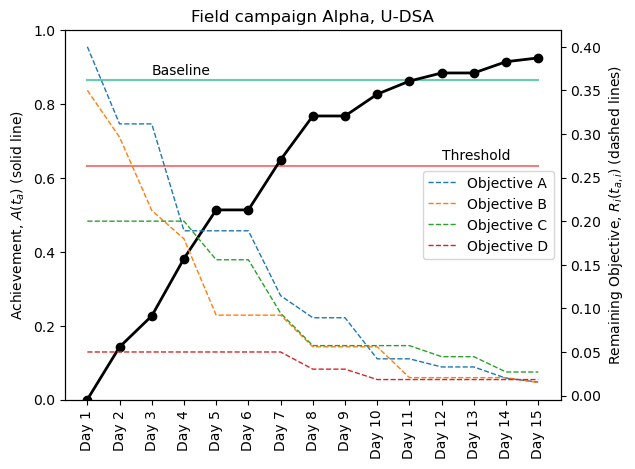

In [133]:
# Create Figure 3: Achievement and Remaining Objective function for Alpha

this_df_vtm=df_alpha
this_df_hrs=df_hours

fig = plt.figure()
fix, ax = plt.subplots()

Ach=np.zeros(this_df_hrs.shape[0])
for index, row in this_df_hrs.iterrows():
    Ach[index]=fcn_achieve(this_df_vtm, this_df_hrs[0:index+1])

pltmax=3.0
pltstep=0.1

ax.plot(this_df_hrs['Date'],np.full(this_df_hrs.shape[0],0.63212056),color='lightcoral')
ax.plot(this_df_hrs['Date'],np.full(this_df_hrs.shape[0],0.86466472),color='mediumaquamarine')
ax.plot(this_df_hrs['Date'],Ach,'o-',linewidth=2, label='Achievement',color='black')
#plt.grid(True, color = "grey", linewidth = "0.5", linestyle = "-.")
ax.set_title(r'Field campaign Alpha, U-DSA')
ax.set_ylabel(r'Achievement, $\it{A(t_a)}$ (solid line)')

ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0,1)

plt.text(11,0.65,'Threshold')
plt.text(2,0.88,'Baseline')


ax2 = ax.twinx()

Rem=np.zeros([this_df_hrs.shape[0],this_df_vtm.shape[0]])
for index, row in this_df_hrs.iterrows():
    Rem[index,:]=fcn_remaining(this_df_vtm, this_df_hrs[0:index+1])

for index, row in this_df_vtm.iterrows():
    ax2.plot(this_df_hrs['Date'],Rem[:,index],'--',linewidth=1, label='Objective '+row['Label'])

ax2.set_ylabel(r'Remaining Objective, $\it{R_i(t_{a,i})}$ (dashed lines)')

ax2.legend(loc='right')

plt.savefig("VTM_fig3.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [134]:
#calculations supporting Expectation function description in section 4
print('First four days of campaign Alpha')
day=4
print(df_hours[0:day+1])
print()

A_day = fcn_achieve(df_alpha, df_hours[0:day])
print('Achievement thus far: ',A_day)
print()

print('Remaining function for each objective (A,B,C,D): ', fcn_remaining(df_alpha, df_hours[0:day]))
print()

prob_forecast = np.array([0.6, 0.7, 0.6, 0.7])
print('Probability of success: ',prob_forecast)
print()

plan1 = np.array([3.0, 0.0, 0.0, 0.0])
plan2 = np.array([0.0, 3.0, 0.0, 0.0])
plan3 = np.array([0.0, 0.0, 3.0, 0.0])
plan4 = np.array([1.0, 1.0, 1.0, 0.0])
plan5 = np.array([0.0, 0.0, 0.0, 3.0])

print('Plan 1: ',fcn_expect(df_alpha, df_hours[0:day], plan1, prob_forecast))
print('Plan 2: ',fcn_expect(df_alpha, df_hours[0:day], plan2, prob_forecast))
print('Plan 3: ',fcn_expect(df_alpha, df_hours[0:day], plan3, prob_forecast))
print('Plan 4: ',fcn_expect(df_alpha, df_hours[0:day], plan4, prob_forecast))
print('Plan 5: ',fcn_expect(df_alpha, df_hours[0:day], plan5, prob_forecast))

First four days of campaign Alpha
    Date  A time  B time  C time  D time
0  Day 1     0.0     0.0     0.0     0.0
1  Day 2     0.5     0.5     0.0     0.0
2  Day 3     0.0     1.0     0.0     0.0
3  Day 4     1.0     0.5     0.0     0.0
4  Day 5     0.0     2.0     0.5     0.0

Achievement thus far:  0.38135738724218693

Remaining function for each objective (A,B,C,D):  [0.18894662 0.17969599 0.2        0.05      ]

Probability of success:  [0.6 0.7 0.6 0.7]

Plan 1:  0.11212665764810423
Plan 2:  0.0904616030521287
Plan 3:  0.11868606805188016
Plan 4:  0.13820448806779767
Plan 5:  0.0438771785873509


In [135]:
#Calculations supporting section 4 demonstration of Climatological Expectation function

p_c = np.asarray(df_alpha['Probability']) #get climatological probability for field campaign Alpha

t_x = np.array([1.0, 1.0, 1.0, 0.0]) #comparison planned flight hours for flight plan 4
flthrs_rem = 42.0 #number of flight hours remaining after 4 days (table 5)
days_rem = 12.0 #number of days remaining
hpd = 6.0 #flight hours per day
day = 4 #campaign day number

p_c_adj=fcn_probadj(p_c,days_rem,flthrs_rem,hpd) #calculate adjusted climatological probability
print('p`_c: ',p_c_adj)

R_x = fcn_remaining(df_alpha, df_hours[0:day]) #calculate remaining objective after 4 days
print('R:    ', R_x)

t_c = fcn_timepart(R_x, t_x, p_c_adj) #calculate planned flight hours for climatological partition
print('t_c:  ', t_c)

E_c = fcn_expect(df_alpha, df_hours[0:day], t_c, p_c_adj) #calculate Climatological Expectation Function
print('E_c:  ', E_c)


p`_c:  [0.83193 0.83193 0.83193 0.83193]
R:     [0.18894662 0.17969599 0.2        0.05      ]
t_c:   [0.91626385 0.84708184 0.8933577  0.21472037]
E_c:   0.16775378821463185


Overlap hours:  5.535698393077873
S(80.9)=  0.816878456084707


<Figure size 640x480 with 0 Axes>

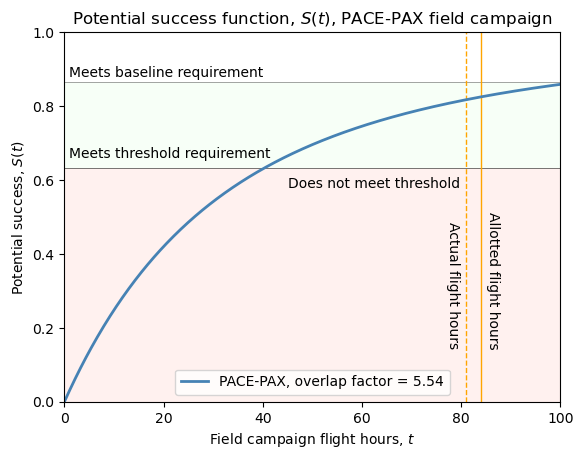

In [136]:
# Create Figure 4: PACE-PAX Potential success function

fig = plt.figure()
fix, ax = plt.subplots()

hrs_overlap = (79.3+177.238+75.5+115.8) / 80.9 #as enacted during PACE-PAX
# hrs_overlap = 7 #this matches practice
print('Overlap hours: ',hrs_overlap)
print('S(80.9)= ',fcn_psf(df_pacepax,80.9*hrs_overlap))

pltmax=100*hrs_overlap
pltstep=1
obs_time = np.arange(0,pltmax,pltstep)

S_alpha = fcn_psf(df_pacepax,obs_time)
Smax_alpha = fcn_psfm(df_pacepax)
                      
ax.plot([84.,84.],[0,1],linewidth='1',color='orange')
ax.plot([80.9,80.9],[0,1],'--',linewidth='1',color='orange',)
ax.plot(obs_time/hrs_overlap,S_alpha,label=r'PACE-PAX, overlap factor = %.2f' % hrs_overlap, 
        linewidth='2', color='steelblue')

ax.set_title(r'Potential success function, $\it{S(t)}$, PACE-PAX field campaign')
ax.set_xlabel(r'Field campaign flight hours, $\it{t}$')
ax.set_ylabel(r'Potential success, $\it{S(t)}$')
ax.set_xlim(0,pltmax/hrs_overlap)
ax.set_ylim(0,1)
ax.legend(loc='lower center')

rect_baseline = Rectangle((0.0,0.632), width=pltmax, height=0.865-0.632, alpha=0.5,
                 facecolor='honeydew',edgecolor='black',linewidth=0.5)
ax.add_patch(rect_baseline)
rect_threshold = Rectangle((0.0,0.0), width=pltmax, height=0.632, alpha=0.5, 
                 facecolor='mistyrose',edgecolor='black',linewidth=0.5)
ax.add_patch(rect_threshold)

plt.text(45,0.58,'Does not meet threshold')

plt.text(1,0.66,'Meets threshold requirement')

plt.text(1,0.88,'Meets baseline requirement')

plt.text(85,0.15,'Allotted flight hours',rotation=270)
plt.text(77,0.15,'Actual flight hours',rotation=270)

plt.savefig("VTM_fig4.pdf", format="pdf", bbox_inches="tight")
plt.show()

0.8381746086610512


<Figure size 640x480 with 0 Axes>

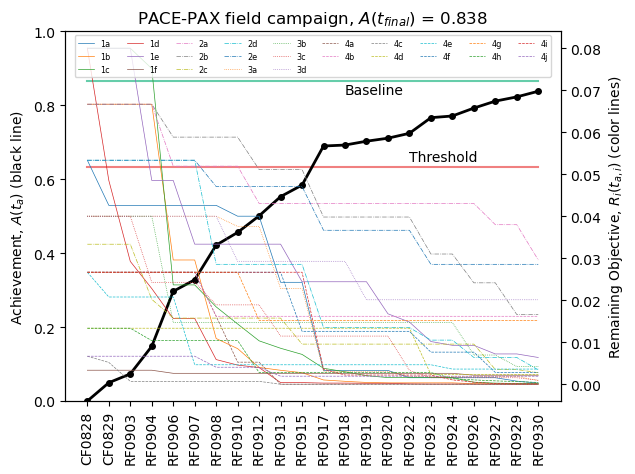

In [147]:
# Create Figure 5: Achievement and Remaining Objective function for PACE-PAX

this_df_vtm=df_pacepax
this_df_hrs=df_pacepax_hrs

fig = plt.figure()
fix, ax = plt.subplots()

Ach=np.zeros(this_df_hrs.shape[0])
for index, row in this_df_hrs.iterrows():
    Ach[index]=fcn_achieve(this_df_vtm, this_df_hrs[0:index+1])
print(Ach[-1])
pltmax=3.0
pltstep=0.1

ax.plot(this_df_hrs['Date'],np.full(this_df_hrs.shape[0],0.63212056),color='lightcoral')
ax.plot(this_df_hrs['Date'],np.full(this_df_hrs.shape[0],0.86466472),color='mediumaquamarine')
ax.plot(this_df_hrs['Date'],Ach,'o-',linewidth=2, label='Achievement',color='black',markersize=4)
#plt.grid(True, color = "grey", linewidth = "0.5", linestyle = "-.")
ax.set_title(r'PACE-PAX field campaign, $\it{A(t_{final})}$ = %.3f' % Ach[-1])
ax.set_ylabel(r'Achievement, $\it{A(t_a)}$ (black line)')

ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0,1)

plt.text(15,0.65,'Threshold')
plt.text(12,0.83,'Baseline')


ax2 = ax.twinx()

Rem=np.zeros([this_df_hrs.shape[0],this_df_vtm.shape[0]])
for index, row in this_df_hrs.iterrows():
    Rem[index,:]=fcn_remaining(this_df_vtm, this_df_hrs[0:index+1])


this_linestyle=['-','-','-','-','-','-','-.','-.','-.','-.','-.',':',':',':',':','--','--','--','--','--','--','--','--','--','--']

for index, row in this_df_vtm.iterrows():
    ax2.plot(this_df_hrs['Date'],Rem[:,index],linestyle=this_linestyle[index],linewidth=0.5, label=row['Label'])

ax2.set_ylabel(r'Remaining Objective, $\it{R_i(t_{a,i})}$ (color lines)')

ax2.legend(loc='upper center',ncols=10,fontsize='xx-small')

plt.savefig("VTM_fig5.pdf", format="pdf", bbox_inches="tight")
plt.show()
